# forecasting selling price of chicken with Bins

In [24]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

!pip install category_encoders
import category_encoders as ce
from category_encoders import TargetEncoder


In [63]:
# reading file
df = pd.read_csv('/workspaces/forecasting/data/data.csv')
df.head()

,DAY_DATE,UNIT,TAILS,KG,SALES PER KG,TOTAL SALES,ABW,CHICKEN SIZE,PROVINCE
0,2017-01-01,LOMBOK,6237,11356.5,22000.00000,249843000,1.820827,MEDIUM,NUSA TENGGARA BARAT
1,2017-01-01,GARUT,2625,5446.8,17000.00000,92595600,2.074971,LARGE,JAWA BARAT
2,2017-01-01,SUMEDANG,7788,14176.8,16106.05355,228332300,1.820339,MEDIUM,JAWA BARAT
3,2017-01-01,CIREBON,7504,15958.0,17000.00000,271286000,2.126599,LARGE,JAWA BARAT
4,2017-01-01,PEKALONGAN,9121,16250.0,16500.00000,268125000,1.781603,MEDIUM,JAWA TENGAH


# cleaning

In [64]:
# changing the value name such that it matches the values in the supply and demand dataset
# finding for any nan values
df.isna().sum()
# pring out the rows with nan values
df[df.isna().any(axis=1)]

# change value name of the province column
df['PROVINCE'] = df['PROVINCE'].replace('DIY YOGYAKARTA', 'DI YOGYAKARTA')
# print out the unique values of the province column
df['PROVINCE'].unique()

# removing outlier
df = df[df['SALES PER KG'] <= 35000] # removing values that are more than 35000
df = df[df['SALES PER KG'] > 0] # taking values that are more than 0

# removing 'total sales' column
df = df.drop('TOTAL SALES', axis = 1)



In [65]:
df.describe()

,TAILS,KG,SALES PER KG,ABW
count,382895.000000,382895.000000,382895.000000,382895.000000
mean,6216.175150,11514.746673,18014.294580,1.864465
std,6125.450527,11925.749132,3273.056777,0.396896
min,4.000000,6.500000,7.461648,0.230000
25%,1872.000000,2999.100000,16000.000000,1.589617
50%,4480.000000,8057.800000,17900.000000,1.833759
75%,8672.000000,15943.050000,20003.159580,2.134752
max,141479.000000,286486.800000,34417.448410,3.975700


In [60]:
'''

# creating bins for prediction


# Assuming 'prices' is the pandas Series containing the selling price data
# Let's say you want to start with 5 quantile bins
num_quantile_bins = 
prices = df['SALES PER KG']

# Use qcut to create bins with an approximately equal number of observations
# 'retbins=True' will return the actual bin edge values so you can see the ranges
price_bins, bin_edges = pd.qcut(prices, q=num_quantile_bins, retbins=True, labels=False, duplicates='drop')

# Create a new column 'price_bin' with the bin labels (which are indices in this case)
df['price_bin'] = price_bins

# Now, to show the actual price ranges for each bin, we'll create bin labels
bin_labels = [f"{int(bin_edges[i])}-{int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

# Assign these labels to the bins in the DataFrame
df['price_bin_range'] = pd.qcut(prices, q=num_quantile_bins, labels=bin_labels, duplicates='drop')

# Check the distribution in each bin
print(df['price_bin_range'].value_counts())

# To see the ranges of the bins
print(bin_edges)
'''

price_bin_range
17900-18500    35740
20003-21000    33487
13951-15200    32736
21000-22500    32178
16708-17300    32138
7-13951        31908
19176-20003    31908
17300-17900    31808
15200-16000    31526
16000-16708    31462
22500-34417    30059
18500-19176    27945
Name: count, dtype: int64
[7.46164806e+00 1.39517594e+04 1.52000000e+04 1.60000000e+04
 1.67082686e+04 1.73000000e+04 1.79000000e+04 1.85000000e+04
 1.91763216e+04 2.00031596e+04 2.10000000e+04 2.25000000e+04
 3.44174484e+04]


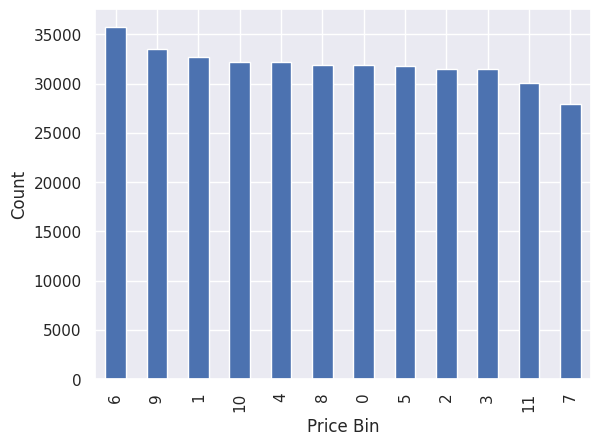

In [61]:
'''# classes
sns.set()
price_bin = df['price_bin'].value_counts().plot(kind = 'bar')
plt.xlabel('Price Bin')
plt.ylabel('Count')
plt.show()'''

## pre processing
- extracting date column
- splitting, scaling
- creating function to evaluate the model [call `results(y_test, predictions)`]


In [68]:
# extracting year and month from date column for seasonality trends
df['DAY_DATE'] = pd.to_datetime(df['DAY_DATE'], errors='coerce').dt.normalize()
df['YEAR'] = df['DAY_DATE'].dt.year
df['MONTH'] = df['DAY_DATE'].dt.month
df['DAY'] = df['DAY_DATE'].dt.day
df = df.drop('DAY_DATE', axis = 1)


In [69]:
df

,UNIT,TAILS,KG,SALES PER KG,ABW,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY
0,LOMBOK,6237,11356.5,22000.00000,1.820827,MEDIUM,NUSA TENGGARA BARAT,2017,1,1
1,GARUT,2625,5446.8,17000.00000,2.074971,LARGE,JAWA BARAT,2017,1,1
2,SUMEDANG,7788,14176.8,16106.05355,1.820339,MEDIUM,JAWA BARAT,2017,1,1
3,CIREBON,7504,15958.0,17000.00000,2.126599,LARGE,JAWA BARAT,2017,1,1
4,PEKALONGAN,9121,16250.0,16500.00000,1.781603,MEDIUM,JAWA TENGAH,2017,1,1
...,...,...,...,...,...,...,...,...,...,...
382897,SRAGEN,510,618.4,16500.00000,1.210000,SMALL,JAWA TENGAH,2024,1,27
382898,SLEMAN,48,63.2,12000.00000,1.320000,SMALL,DI YOGYAKARTA,2024,1,28
382899,SRAGEN,315,415.6,16800.00000,1.320000,SMALL,JAWA TENGAH,2024,1,28
382900,BOYOLALI,785,974.8,16000.00000,1.240000,SMALL,JAWA TENGAH,2024,1,28


## demand and supply
importing the demand and supply dataset

In [70]:
# filtering for rows for year 2019 to 2023
df = df[(df['YEAR'] >= 2019) & (df['YEAR'] <= 2023)]

# removine rows that are earlier than december 2019
df = df[(df['YEAR'] >= 2019) & (df['MONTH'] >= 12)]


In [71]:
df

,UNIT,TAILS,KG,SALES PER KG,ABW,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY
165114,PAYAKUMBUH,1267,2856.0,18000.00000,2.254144,LARGE,SUMATERA BARAT,2019,12,1
165115,SINJAI,3310,7799.5,22637.89730,2.356344,LARGE,SULAWESI SELATAN,2019,12,1
165116,BANDAR JAYA,8236,22197.0,15905.01419,2.695119,LARGE,LAMPUNG,2019,12,1
165117,BANDAR LAMPUNG,2565,4971.0,18060.47073,1.938012,MEDIUM,LAMPUNG,2019,12,1
165118,BANYUASIN,696,1464.4,16368.88828,2.104023,LARGE,SUMATERA SELATAN,2019,12,1
...,...,...,...,...,...,...,...,...,...,...
382498,BOYOLALI,430,901.4,15800.00000,2.100000,BIG,JAWA TENGAH,2023,12,31
382499,BOYOLALI,294,605.0,15800.00000,2.060000,BIG,JAWA TENGAH,2023,12,31
382500,BOYOLALI,432,962.4,15800.00000,2.230000,BIG,JAWA TENGAH,2023,12,31
382501,GUNUNGKIDUL,200,370.8,16200.00000,1.850000,MEDIUM,DI YOGYAKARTA,2023,12,31


In [72]:
# importing demand and supply dataset
df_demand_supply = pd.read_csv('/workspaces/forecasting/data/provinceDD&SS.csv')
df_demand_supply

# splitting the month_year column into separate month and year columns
df_demand_supply[['MONTH', 'YEAR']] = df_demand_supply['Month_Year'].str.split(' ', expand = True)

# mapping month to numerical values
month_num = {
    'Jan' : 1, 'Feb' : 2, 'Mar' : 3, 'Apr' : 4, 'May' : 5, 'Jun' : 6, 'Jul' : 7, 
    'Aug' : 8, 'Sep' : 9, 'Oct' : 10, 'Nov' : 11, 'Dec' : 12
}

# replacing month with numerical values
df_demand_supply['MONTH'] = df_demand_supply['MONTH'].replace(month_num)
df_demand_supply['YEAR'] = df_demand_supply['YEAR'].astype(int)

# dropping original month_year column
df_demand_supply.drop('Month_Year', axis = 1, inplace = True)
df_demand_supply

/tmp/ipykernel_1935/4092989005.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_demand_supply['MONTH'] = df_demand_supply['MONTH'].replace(month_num)


,PROVINCE,SupplyProvince,DemandProvince,MONTH,YEAR
0,ACEH,2687246,3930723,12,2019
1,BALI,5120529,5141045,12,2019
2,BANTEN,16349469,13433846,12,2019
3,BENGKULU,554903,1339242,12,2019
4,DI YOGYAKARTA,4206148,6313628,12,2019
...,...,...,...,...,...
1723,SULAWESI TENGGARA,104238,705272,12,2023
1724,SULAWESI UTARA,396941,1307670,12,2023
1725,SUMATERA BARAT,3689089,4922821,12,2023
1726,SUMATERA SELATAN,5467836,5767260,12,2023


In [73]:
# merging the demand and supply dataset with the main dataset
df = pd.merge(df, df_demand_supply, how = 'inner', on = ['YEAR', 'MONTH', 'PROVINCE'])
df

,UNIT,TAILS,KG,SALES PER KG,ABW,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY,SupplyProvince,DemandProvince
0,PAYAKUMBUH,1267,2856.0,18000.00000,2.254144,LARGE,SUMATERA BARAT,2019,12,1,3885216,5993194
1,SINJAI,3310,7799.5,22637.89730,2.356344,LARGE,SULAWESI SELATAN,2019,12,1,5447863,5931514
2,BANDAR JAYA,8236,22197.0,15905.01419,2.695119,LARGE,LAMPUNG,2019,12,1,5404511,5618463
3,BANDAR LAMPUNG,2565,4971.0,18060.47073,1.938012,MEDIUM,LAMPUNG,2019,12,1,5404511,5618463
4,BANYUASIN,696,1464.4,16368.88828,2.104023,LARGE,SUMATERA SELATAN,2019,12,1,5758528,7021239
...,...,...,...,...,...,...,...,...,...,...,...,...
15050,BOYOLALI,430,901.4,15800.00000,2.100000,BIG,JAWA TENGAH,2023,12,31,54958385,26285612
15051,BOYOLALI,294,605.0,15800.00000,2.060000,BIG,JAWA TENGAH,2023,12,31,54958385,26285612
15052,BOYOLALI,432,962.4,15800.00000,2.230000,BIG,JAWA TENGAH,2023,12,31,54958385,26285612
15053,GUNUNGKIDUL,200,370.8,16200.00000,1.850000,MEDIUM,DI YOGYAKARTA,2023,12,31,3993820,5186026


## finding the best number of bins


In [75]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
import numpy as np
import xgboost as xgb

prices = df['SALES PER KG']

# Define a range of possible bin numbers
bin_range = range(5, 16)  # for example, from 2 to 20 bins

# Define a scoring function, e.g., F1 score
scoring_function = make_scorer(f1_score, average='weighted')

# Prepare a dictionary to hold cross-validation results
cv_results = {}

for bins in bin_range:
    # Bin the data
    df['price_bin'], bin_edges = pd.qcut(prices, q=bins, retbins=True, labels=False, duplicates='drop')
    
    X = df
    X_encoded = pd.get_dummies(X, columns=['UNIT', 'CHICKEN SIZE', 'PROVINCE'])
    y = df['price_bin']  # your newly binned target variable
    # One-hot encode categorical variables


    # Initialize XGBClassifier (or any other model you're using)
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=bins, max_depth = 5, enable_categorical=True,)
    
    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_encoded, y, cv=cv, scoring=scoring_function)
    
    # Store the average cross-validation score
    cv_results[bins] = np.mean(cv_scores)

# Find the number of bins with the best average F1 score
best_bin_number = max(cv_results, key=cv_results.get)
print(f"Best number of bins: {best_bin_number} with F1 Score: {cv_results[best_bin_number]}")


Best number of bins: 5 with F1 Score: 1.0


In [13]:
# train test split before label encoding to prevent data leakage


X = df.drop('price_bin', axis=1)
y = df['price_bin']

# removing classes that have samples less than 2
threshold = 2
class_counts = y.value_counts()
small_classes = class_counts[class_counts < threshold].index

# removing samples belonging to small classes
y_filtered = y[~y.isin(small_classes)]
X_filtered = X.loc[y_filtered.index]


X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)


# checking for any nan values after splitting
print(X_train.isna().sum())
print(X_test.isna().sum())
print(y_train.isna().sum())
print(y_test.isna().sum())




UNIT              0
TAILS             0
KG                0
CHICKEN SIZE      0
PROVINCE          0
YEAR              0
MONTH             0
DAY               0
SupplyProvince    0
DemandProvince    0
dtype: int64
UNIT              0
TAILS             0
KG                0
CHICKEN SIZE      0
PROVINCE          0
YEAR              0
MONTH             0
DAY               0
SupplyProvince    0
DemandProvince    0
dtype: int64
0
0


In [14]:
# printing out the nan rows in the x_train dataset
X_train[X_train.isna().any(axis=1)] 


,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY,SupplyProvince,DemandProvince


In [15]:
# scaling numerical variable

scaler = StandardScaler()
columns_to_scale = ['KG', 'TAILS', 'SupplyProvince', 'DemandProvince']
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [16]:
X_train

,UNIT,TAILS,KG,CHICKEN SIZE,PROVINCE,YEAR,MONTH,DAY,SupplyProvince,DemandProvince
6463,KARANGASEM,-0.872846,-0.862323,MEDIUM,BALI,2020,12,10,-0.916943,-0.924149
9726,BALIKPAPAN,0.059049,0.155902,LARGE,KALIMANTAN TIMUR,2021,12,2,-1.022624,-0.962814
13769,BOJONEGORO,-0.933067,-0.870435,LARGE,JAWA TIMUR,2021,12,27,0.090720,0.850420
10131,BOJONEGORO,0.263272,-0.058983,SMALL,JAWA TIMUR,2021,12,4,0.090720,0.850420
10643,DEMAK,0.689839,0.455114,MEDIUM,JAWA TENGAH,2021,12,7,0.789468,0.287419
...,...,...,...,...,...,...,...,...,...,...
5192,KARANGASEM,0.852101,0.913293,MEDIUM,BALI,2020,12,1,-0.916943,-0.924149
13419,BANGKINANG,0.396957,0.330484,MEDIUM,RIAU,2021,12,24,-0.763180,-0.872158
5391,SERANG,-0.269240,-0.542749,SMALL,BANTEN,2020,12,2,-0.468474,-0.454299
860,SUBANG(P),1.897051,1.165433,SMALL,JAWA BARAT,2019,12,5,1.671334,1.891485


In [17]:
# creating function to evaluate the model
def results(y_test, predictions):
  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, predictions)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Mean Squared Error (MSE): {mse}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R-squared (R²): {r2}")


# encoding

In [18]:
# encoding of columns
# label encoding for province

label_encoder = LabelEncoder()
X_train['SIZE ENCODE'] = label_encoder.fit_transform(X_train['CHICKEN SIZE'])
X_test['SIZE ENCODE'] = label_encoder.transform(X_test['CHICKEN SIZE'])

# dropping chicken size column
X_train = X_train.drop(['CHICKEN SIZE'], axis = 1)
X_test = X_test.drop(['CHICKEN SIZE'], axis = 1)


# one hot encoding for province

encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['PROVINCE']])
X_train_encoded = encoder.transform(X_train[['PROVINCE']])
X_test_encoded = encoder.transform(X_test[['PROVINCE']])

# Convert the encoded matrices back to dataframes for easier manipulation
columns = encoder.get_feature_names_out(['PROVINCE'])
X_train_encoded_df = pd.DataFrame(X_train_encoded.toarray(), columns=columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded.toarray(), columns=columns, index=X_test.index)

# merge back the dataframe
X_train = pd.concat([X_train.drop('PROVINCE', axis=1), X_train_encoded_df], axis=1)
X_test = pd.concat([X_test.drop('PROVINCE', axis=1), X_test_encoded_df], axis=1)


# one hot encoding for unit
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['UNIT']])
X_train_encoded_unit = encoder.transform(X_train[['UNIT']])
X_test_encoded_unit = encoder.transform(X_test[['UNIT']])

# Convert the encoded matrices back to dataframes for easier manipulation
columns = encoder.get_feature_names_out(['UNIT'])
X_train_encoded_df_unit = pd.DataFrame(X_train_encoded_unit.toarray(), columns=columns, index=X_train.index)
X_test_encoded_df_unit = pd.DataFrame(X_test_encoded_unit.toarray(), columns=columns, index=X_test.index)

# merge back the dataframe, dropping unit column
X_train = pd.concat([X_train.drop('UNIT', axis=1), X_train_encoded_df_unit], axis=1)
X_test = pd.concat([X_test.drop('UNIT', axis=1), X_test_encoded_df_unit], axis=1)




# trying lazy predict

In [20]:
pip install lazypredict

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# libraries
import lazypredict
from lazypredict.Supervised import LazyClassifier
'''from sklearn.utils import all_estimators
from sklearn.base import RegressorMixin'''


'from sklearn.utils import all_estimators\nfrom sklearn.base import RegressorMixin'

In [ ]:
print(lazypredict.Supervised.CLASSIFIERS)

[('AdaBoostClassifier', <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>), ('BaggingClassifier', <class 'sklearn.ensemble._bagging.BaggingClassifier'>), ('BernoulliNB', <class 'sklearn.naive_bayes.BernoulliNB'>), ('CalibratedClassifierCV', <class 'sklearn.calibration.CalibratedClassifierCV'>), ('CategoricalNB', <class 'sklearn.naive_bayes.CategoricalNB'>), ('DecisionTreeClassifier', <class 'sklearn.tree._classes.DecisionTreeClassifier'>), ('DummyClassifier', <class 'sklearn.dummy.DummyClassifier'>), ('ExtraTreeClassifier', <class 'sklearn.tree._classes.ExtraTreeClassifier'>), ('ExtraTreesClassifier', <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>), ('GaussianNB', <class 'sklearn.naive_bayes.GaussianNB'>), ('KNeighborsClassifier', <class 'sklearn.neighbors._classification.KNeighborsClassifier'>), ('LabelPropagation', <class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>), ('LabelSpreading', <class 'sklearn.semi_supervised._label_propagation.LabelSp

In [ ]:
'''
    chosen_regressors = [
    'SVR', 
    'BaggingRegressor',
    'ExtraTreesRegressor',
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'LGBMRegressor',
    'XGBRegressor',
    'CatBoostRegressor',
    'HistGradientBoostingRegressor',
    'AdaBoostRegressor',
    'KNeighborsRegressor',
    'DecisionTreeRegressor'
]

REGRESSORS = [
    est
    for est in all_estimators()
    if (issubclass(est[1], RegressorMixin) and est[0] in chosen_regressors)

]'''

# initialising the regressor with chosen regressors
reg = LazyClassifier(verbose=1, ignore_warnings=False, custom_metric=None)


In [ ]:

# fitting and evaluate models
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

  3%|▎         | 1/29 [00:00<00:24,  1.16it/s]

ROC AUC couldn't be calculated for AdaBoostClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'AdaBoostClassifier', 'Accuracy': 0.41149119893723013, 'Balanced Accuracy': 0.1354976736437217, 'ROC AUC': None, 'F1 Score': 0.32996162485507313, 'Time taken': 0.8639228343963623}


  7%|▋         | 2/29 [00:01<00:20,  1.31it/s]

ROC AUC couldn't be calculated for BaggingClassifier
multi_class must be in ('ovo', 'ovr')
{'Model': 'BaggingClassifier', 'Accuracy': 0.7499169711059449, 'Balanced Accuracy': 0.429473765876953, 'ROC AUC': None, 'F1 Score': 0.746572114415542, 'Time taken': 0.6885628700256348}
ROC AUC couldn't be calculated for BernoulliNB
multi_class must be in ('ovo', 'ovr')
{'Model': 'BernoulliNB', 'Accuracy': 0.40983062105612755, 'Balanced Accuracy': 0.24126230101466106, 'ROC AUC': None, 'F1 Score': 0.4031425749212721, 'Time taken': 0.08809232711791992}


In [ ]:
# filtering out the top 5 models
top_5_models = models.head(5)
top_5_models

In [ ]:
y_train.nunique()

# XGB MODEL

In [ ]:
# trying XGBM model
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# label encoding the target variable
label_encoder = LabelEncoder().fit(y_train_resampled)  # Fit on y_train to learn all classes
y_train_encoded = label_encoder.transform(y_train_resampled)
y_test_encoded = label_encoder.transform(y_test)

# Dynamically set the number of classes
num_classes = len(label_encoder.classes_)



# Specify the parameters for XGBoost
params = {
    'objective': 'multi:softmax',  # Specify multi-class classification
    'num_class': num_classes,  # Dynamically set the number of classes
    'max_depth': 4,  # Depth of the trees
    'learning_rate': 0.1,  # Learning rate
    'n_estimators': 100,  # Number of trees
    'seed': 42  # Random seed for reproducibility
}

# Initialize the XGBoost classifier
clf = xgb.XGBClassifier(**params)

# Train the model with encoded targets
clf.fit(X_train_resampled, y_train_encoded)

# Make predictions
y_pred = clf.predict(X_test)

# getting unique classes for predicted labels
unique_y_test = np.unique(y_test_encoded)
unique_y_pred = np.unique(y_pred)

# get unique classes 
all_unique_classes = np.unique(np.concatenate((y_test_encoded, y_pred)))

# map the unique encoded classes back to original names
target_names_adjusted = label_encoder.inverse_transform(all_unique_classes)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))



Accuracy: 61.91%
Confusion Matrix:
[[  0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0   2   2   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0   0   0   0   0   0]
 [  0   1   1  25  15   4   1   0   0   0   0   0]
 [  0   1   0  50 507  99  24  11   4   5   0   0]
 [  1   1   2  25 148 470 111  34  25   4   1   0]
 [  0   0   0   5  30  95 513 141  58   5   2   0]
 [  0   0   0   1   4   8  63 237  79  10   0   0]
 [  0   0   0   1   4   4   4  29  79   8   0   0]
 [  0   0   0   0   0   0   0   5  12  32   0   0]
 [  0   0   0   0   0   0   0   0   2   0   1   0]
 [  0   0   0   0   0   0   0   0   1   0   0   0]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         2
           4       0.23      0.53      0.32        47
           5       0.71      0.72      0.72       701
    

/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.python/current/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

# Neural Network
using entity embeddings to train the neural network


## setting up the model
creating entity embeddings <br>
`cat_col1` = `PROVINCE` <br>
`cat_col2` = `CHICKEN SIZE` <br>
`cat_col3` = `SIZE` <br>

In [ ]:
# original dataset `df`

# importing libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate, Dense, Flatten

# getting the unique values of the categorical columns
cat_columns = ['PROVINCE', 'CHICKEN SIZE', 'UNIT']
unique_cat1 = df['PROVINCE'].nunique()
unique_cat2 = df['CHICKEN SIZE'].nunique()
unique_cat3 = df['UNIT'].nunique()

# getting numerical columns
num_columns = df.columns.difference(cat_columns)
numerical_data = df[num_columns]

# scaling the numerical features
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# defining the input layer
num_input = Input(shape=(numerical_data_scaled.shape[1],), name='num_input')

# embedding the categorical columns
cat_input1 = Input(shape = (1,), name='cat_input1')
cat_embed1 = Embedding(input_dim=unique_cat1, output_dim = int(min(np.ceil(unique_cat1 /2), 50)))(cat_input1)
cat_embed1 = Flatten()(cat_embed1)

cat_input2 = Input(shape = (1,), name='cat_input2')
cat_embed2 = Embedding(input_dim=unique_cat2, output_dim = int(min(np.ceil(unique_cat2 /2), 50)))(cat_input2)
cat_embed2 = Flatten()(cat_embed2)


cat_input3 = Input(shape = (1,), name='cat_input3')
cat_embed3 = Embedding(input_dim=unique_cat3, output_dim = int(min(np.ceil(unique_cat3 /2), 50)))(cat_input3)
cat_embed3 = Flatten()(cat_embed3)


# concatenate the embeddings with numerical input
concatenated = Concatenate()([cat_embed1, cat_embed2, cat_embed3, num_input])


# adding the dense layer ontop of the embeddings
dense_output = Dense(128, activation = 'relu')(concatenated)
dense_output = Dense(64, activation = 'relu')(dense_output)
output = Dense(1)(dense_output)

# creating the model
model = Model(inputs = [cat_input1, cat_input2, cat_input3, num_input], outputs = output)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


## training the model


In [ ]:
# train model
X_train_cat1 = X_train['PROVINCE']
X_train_cat2 = X_train['CHICKEN SIZE']
X_train_cat3 = X_train['UNIT']
X_train_num = X_train.drop(['PROVINCE', 'CHICKEN SIZE', 'UNIT'], axis = 1)

# fitting the model


In [ ]:
df

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np


# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Single output node for regression
])

# Compile the model, specifying the optimizer, loss function, and metric
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model on the training data
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, verbose=1)

# Predict the target on the testing set
predictions = model.predict(X_test).flatten()

# Evaluate the model performance using RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# You can plot the training history to check how the loss and metric evolved over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()
